In [1]:
#6->3->6

## Imports

In [2]:
import random

import pennylane as qml
from pennylane import numpy as np

from pennylane.optimize import AdamOptimizer

import torch
from torchvision import datasets, transforms

C:\Users\tomut\anaconda3\envs\qhack2022\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\tomut\anaconda3\envs\qhack2022\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [3]:
import sys
sys.path.append("..") # Adds higher directory to python modules path

from qencode.initialize import setAB_amplitude, setAux, setEnt
from qencode.encoders import e2_classic
from qencode.training_circuits import swap_t
from qencode.qubits_arrangement import QubitsArrangement

from qencode.utils.mnist import get_dataset

## Get Data

In [4]:
input_data = get_dataset(img_width=8, img_height=8, train=True)
print("Original data set size:", len(input_data))

# Select only the pictures with numbers 0 or 1. (jus to compare with literature)
filtered_data = [image for image in input_data if image[1] in [0, 1]]
input_data = filtered_data
print("Final data set szize:", len(input_data))

Original data set size: 60000
Final data set szize: 12665


## Training node

In [5]:
shots = 2500
nr_trash=3
nr_latent=3
nr_ent=0
spec = QubitsArrangement(nr_trash, nr_latent, nr_swap=1, nr_ent=nr_ent)
print("Qubits:", spec.qubits)

#set up the device 
dev = qml.device("default.qubit", wires=spec.num_qubits)

Qubits: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [6]:
@qml.qnode(dev)
def training_circuit_example(init_params, encoder_params, reinit_state):
    #initilaization
    setAB_amplitude(spec, *init_params)

    setAux(spec, reinit_state)

    setEnt(spec, inputs=[1 / np.sqrt(2), 0, 0, 1 / np.sqrt(2)])

    #encoder

    for params in encoder_params:
        e2_classic(params, [*spec.latent_qubits, *spec.trash_qubits])

    #swap test 
    swap_t(spec)

    return [qml.probs(i) for i in spec.swap_qubits]

## Training parameters 

In [7]:
epochs = 2000
learning_rate = 0.0003
batch_size = 5
num_samples = 20

beta1 = 0.9
beta2 = 0.999
opt = AdamOptimizer(learning_rate, beta1=beta1, beta2=beta2)

In [8]:
def fid_func(output):
    # Implemented as the Fidelity Loss
    # output[0] because we take the probability that the state after the 
    # SWAP test is ket(0), like the reference state
    fidelity_loss = 1 / output[0]
    return fidelity_loss

In [9]:
def cost(encoder_params, X):
    reinit_state = [0 for i in range(2 ** len(spec.aux_qubits))]
    reinit_state[0] = 1.0
    loss = 0.0
    for x in X:
        output = training_circuit_example(init_params=x[0], encoder_params=encoder_params, reinit_state=reinit_state)[0]
        f = fid_func(output)
        loss = loss + f
    return loss / len(X)

In [10]:
def fidelity(encoder_params, X):
    reinit_state = [0 for i in range(2 ** len(spec.aux_qubits))]
    reinit_state[0] = 1.0
    loss = 0.0
    for x in X:
        output = training_circuit_example(init_params=x[0], encoder_params=encoder_params, reinit_state=reinit_state)[0]
        f = output[0]
        loss = loss + f
    return loss / len(X)

In [11]:
def iterate_batches(X, batch_size):
    X1 = [torch.reshape(x[0], (1, 2 ** (len(spec.latent_qubits) + len(spec.trash_qubits)))) for x in X]
    X2 = []
    for i in range(len(X1)):
        X2.append([X1[1], X[i][1]])
    X = X2
    random.shuffle(X)

    batch_list = []
    batch = []
    for x in X:
        if len(batch) < batch_size:
            batch.append(x)

        else:
            batch_list.append(batch)
            batch = []
    if len(batch) != 0:
        batch_list.append(batch)
    return batch_list

In [12]:
training_data = [input_data[i] for i in range(num_samples)]
test_data = [input_data[i] for i in range(num_samples,num_samples+num_samples)]

In [13]:
X1 = [torch.reshape(x[0], (1, 2 ** (len(spec.latent_qubits) + len(spec.trash_qubits)))) for x in training_data]
X2 = []
for i in range(len(X1)):
    X2.append([X1[1], training_data[i][1]])
X_training = X2

X1 = [torch.reshape(x[0], (1, 2 ** (len(spec.latent_qubits) + len(spec.trash_qubits)))) for x in test_data]
X2 = []
for i in range(len(X1)):
    X2.append([X1[1], training_data[i][1]])
X_tes = X2

In [14]:
# initialize random encoder parameters
nr_encod_qubits = len(spec.trash_qubits) + len(spec.latent_qubits)
nr_par_encoder =  15 * int(nr_encod_qubits*(nr_encod_qubits-1)/2)
encoder_params = np.random.uniform(size=(1, nr_par_encoder), requires_grad=True)


###  training

In [15]:
loss_hist=[]
fid_hist=[]

loss_hist_test=[]
fid_hist_test=[]

for epoch in range(epochs):
    batches = iterate_batches(X=training_data, batch_size=batch_size)
    for xbatch in batches:
        encoder_params = opt.step(cost, encoder_params, X=xbatch)

        
    if epoch%5 == 0:
        
        loss_training = cost(encoder_params, X_training )
        fidel = fidelity(encoder_params, X_training )
        
        loss_hist.append(loss_training)
        fid_hist.append(fidel)
        print("Epoch:{} | Loss:{} | Fidelity:{}".format(epoch, loss_training, fidel))

        loss_test = cost(encoder_params, X_tes )
        fidel = fidelity(encoder_params, X_tes )
        loss_hist_test.append(loss_test)
        fid_hist_test.append(fidel)
        print("Test-Epoch:{} | Loss:{} | Fidelity:{}".format(epoch, loss_test, fidel))

C:\Users\tomut\anaconda3\envs\qhack2022\lib\site-packages\pennylane\math\multi_dispatch.py:63: UserWarning: Contains tensors of types {'torch', 'autograd'}; dispatch will prioritize TensorFlow and PyTorch over autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


Epoch:0 | Loss:1.689626972863465 | Fidelity:0.5918466123355428
Test-Epoch:0 | Loss:1.6950914955542242 | Fidelity:0.5899386567761886
Epoch:5 | Loss:1.6404249391132624 | Fidelity:0.6095981450638968
Test-Epoch:5 | Loss:1.6439878571387692 | Fidelity:0.6082769989192138
Epoch:10 | Loss:1.596047879654865 | Fidelity:0.6265476197469989
Test-Epoch:10 | Loss:1.5968206475796975 | Fidelity:0.6262444072950212
Epoch:15 | Loss:1.5560606955163536 | Fidelity:0.642648453804796
Test-Epoch:15 | Loss:1.554133626900459 | Fidelity:0.6434453142838077
Epoch:20 | Loss:1.5198252713545057 | Fidelity:0.6579703725473488
Test-Epoch:20 | Loss:1.5157933447961254 | Fidelity:0.6597205373892839
Epoch:25 | Loss:1.486850375665792 | Fidelity:0.6725626306226093
Test-Epoch:25 | Loss:1.4814479391453792 | Fidelity:0.6750152830729123
Epoch:30 | Loss:1.4568069030450097 | Fidelity:0.6864327715017038
Test-Epoch:30 | Loss:1.4506539104866898 | Fidelity:0.6893442969208988
Epoch:35 | Loss:1.4295162769073568 | Fidelity:0.6995373303222681

Epoch:305 | Loss:1.0874194822174625 | Fidelity:0.9196083170781559
Test-Epoch:305 | Loss:1.0934934715910853 | Fidelity:0.9145002014003355
Epoch:310 | Loss:1.0856653809793193 | Fidelity:0.9210941211904119
Test-Epoch:310 | Loss:1.092165588066737 | Fidelity:0.9156120746947531
Epoch:315 | Loss:1.083962505218723 | Fidelity:0.9225411351273806
Test-Epoch:315 | Loss:1.0908816794269218 | Fidelity:0.916689700504765
Epoch:320 | Loss:1.0823104071095702 | Fidelity:0.9239493526359143
Test-Epoch:320 | Loss:1.0896418100882124 | Fidelity:0.9177327730468093
Epoch:325 | Loss:1.0807086881217516 | Fidelity:0.9253187385196086
Test-Epoch:325 | Loss:1.0884460726365508 | Fidelity:0.9187409694792624
Epoch:330 | Loss:1.079156956335639 | Fidelity:0.926649264621874
Test-Epoch:330 | Loss:1.0872945196616695 | Fidelity:0.919714007490047
Epoch:335 | Loss:1.0776547888976713 | Fidelity:0.9279409420366387
Test-Epoch:335 | Loss:1.086187106424949 | Fidelity:0.9206516944317047
Epoch:340 | Loss:1.0762017007906726 | Fidelity:0

Test-Epoch:605 | Loss:1.058626015628317 | Fidelity:0.9446206547328039
Epoch:610 | Loss:1.0391551315869472 | Fidelity:0.9623202249628011
Test-Epoch:610 | Loss:1.0582094644718896 | Fidelity:0.9449924930496255
Epoch:615 | Loss:1.0387607876062535 | Fidelity:0.9626855498698849
Test-Epoch:615 | Loss:1.057790287680316 | Fidelity:0.945366970794327
Epoch:620 | Loss:1.038369551732117 | Fidelity:0.9630482695990921
Test-Epoch:620 | Loss:1.057368833891402 | Fidelity:0.9457437820630016
Epoch:625 | Loss:1.037981480380695 | Fidelity:0.9634083255832607
Test-Epoch:625 | Loss:1.0569454813505685 | Fidelity:0.946122593496683
Epoch:630 | Loss:1.0375966367113858 | Fidelity:0.963765652873985
Test-Epoch:630 | Loss:1.0565206319963383 | Fidelity:0.9465030494581633
Epoch:635 | Loss:1.037215086935613 | Fidelity:0.964120183552707
Test-Epoch:635 | Loss:1.0560947053084484 | Fidelity:0.9468847774479986
Epoch:640 | Loss:1.0368368968517285 | Fidelity:0.9644718499471023
Test-Epoch:640 | Loss:1.0556681321161994 | Fidelity

Epoch:910 | Loss:1.0189229905427304 | Fidelity:0.9814284389317282
Test-Epoch:910 | Loss:1.0383171883601832 | Fidelity:0.963096837084343
Epoch:915 | Loss:1.0185339582008681 | Fidelity:0.9818032987004128
Test-Epoch:915 | Loss:1.038132416983552 | Fidelity:0.9632682532982149
Epoch:920 | Loss:1.0181403210333866 | Fidelity:0.9821828871142488
Test-Epoch:920 | Loss:1.0379523576912537 | Fidelity:0.9634353567290187
Epoch:925 | Loss:1.0177424550995016 | Fidelity:0.9825668517505571
Test-Epoch:925 | Loss:1.0377770705789298 | Fidelity:0.9635980870555796
Epoch:930 | Loss:1.017340825755682 | Fidelity:0.9829547529041692
Test-Epoch:930 | Loss:1.0376066324600877 | Fidelity:0.9637563684698842
Epoch:935 | Loss:1.016935989174757 | Fidelity:0.9833460617432761
Test-Epoch:935 | Loss:1.0374411350338626 | Fidelity:0.9639101113600624
Epoch:940 | Loss:1.0165285916870928 | Fidelity:0.9837401605599098
Test-Epoch:940 | Loss:1.037280681856029 | Fidelity:0.9640592151110707
Epoch:945 | Loss:1.0161193666174015 | Fidelity

Epoch:1210 | Loss:1.0042044626501325 | Fidelity:0.9958131408428155
Test-Epoch:1210 | Loss:1.0330028677866152 | Fidelity:0.9680515235574031
Epoch:1215 | Loss:1.0041350389431887 | Fidelity:0.9958819891918719
Test-Epoch:1215 | Loss:1.0329435703059175 | Fidelity:0.9681070958250299
Epoch:1220 | Loss:1.004067587575554 | Fidelity:0.995948890666439
Test-Epoch:1220 | Loss:1.0328843348052918 | Fidelity:0.968162616377089
Epoch:1225 | Loss:1.0040019855607125 | Fidelity:0.9960139664878476
Test-Epoch:1225 | Loss:1.0328251635547474 | Fidelity:0.9682180830666726
Epoch:1230 | Loss:1.0039381174717346 | Fidelity:0.9960773304617095
Test-Epoch:1230 | Loss:1.0327660630105444 | Fidelity:0.9682734898210832
Epoch:1235 | Loss:1.0038758751633101 | Fidelity:0.9961390892447934
Test-Epoch:1235 | Loss:1.0327070436456487 | Fidelity:0.9683288267985596
Epoch:1240 | Loss:1.0038151574836969 | Fidelity:0.9961993426227383
Test-Epoch:1240 | Loss:1.032648119718935 | Fidelity:0.968384080602576
Epoch:1245 | Loss:1.003755869979

Test-Epoch:1505 | Loss:1.0303539211170816 | Fidelity:0.9705402964020633
Epoch:1510 | Loss:1.001621859894288 | Fidelity:0.9983807662759482
Test-Epoch:1510 | Loss:1.03033405754701 | Fidelity:0.9705590072221544
Epoch:1515 | Loss:1.0015943182657927 | Fidelity:0.9984082195388714
Test-Epoch:1515 | Loss:1.0303150218263397 | Fidelity:0.9705769389127191
Epoch:1520 | Loss:1.0015671730177107 | Fidelity:0.9984352791705537
Test-Epoch:1520 | Loss:1.0302967968134527 | Fidelity:0.9705941075356573
Epoch:1525 | Loss:1.001540420206036 | Fidelity:0.9984619490387429
Test-Epoch:1525 | Loss:1.030279364975224 | Fidelity:0.9706105295276369
Epoch:1530 | Loss:1.0015140559243108 | Fidelity:0.9984882329755088
Test-Epoch:1530 | Loss:1.0302627084645348 | Fidelity:0.9706262216268728
Epoch:1535 | Loss:1.001488076333462 | Fidelity:0.9985141347474558
Test-Epoch:1535 | Loss:1.0302468091958192 | Fidelity:0.9706412008017488
Epoch:1540 | Loss:1.001462477689254 | Fidelity:0.9985396580282991
Test-Epoch:1540 | Loss:1.030231648

Epoch:1805 | Loss:1.0005876354620977 | Fidelity:0.9994127096505384
Test-Epoch:1805 | Loss:1.0300713526527228 | Fidelity:0.9708065343480522
Epoch:1810 | Loss:1.0005787863997109 | Fidelity:0.9994215484002072
Test-Epoch:1810 | Loss:1.0300737703138514 | Fidelity:0.9708042557916133
Epoch:1815 | Loss:1.000570138317361 | Fidelity:0.9994301865551168
Test-Epoch:1815 | Loss:1.0300761632582591 | Fidelity:0.9708020005403053
Epoch:1820 | Loss:1.0005616856192048 | Fidelity:0.9994386296944228
Test-Epoch:1820 | Loss:1.0300785214599482 | Fidelity:0.9707997780428265
Epoch:1825 | Loss:1.0005534227506971 | Fidelity:0.9994468833566369
Test-Epoch:1825 | Loss:1.0300808353197755 | Fidelity:0.9707975973454191
Epoch:1830 | Loss:1.0005453442097083 | Fidelity:0.999454953028501
Test-Epoch:1830 | Loss:1.0300830956882832 | Fidelity:0.9707954670703705
Epoch:1835 | Loss:1.0005374445571071 | Fidelity:0.9994628441343888
Test-Epoch:1835 | Loss:1.030085293886128 | Fidelity:0.9707933953967756
Epoch:1840 | Loss:1.0005297184

## Rezults

In [16]:
import matplotlib.pyplot as plt

fidelity: 0.9996477841135343


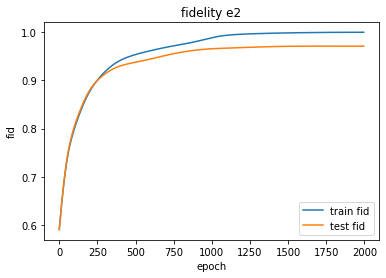

In [17]:
fig = plt.figure()
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(fid_hist),label="train fid")
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(fid_hist_test),label="test fid")


plt.legend()
plt.title("fidelity e2",)
plt.xlabel("epoch")
plt.ylabel("fid")

print("fidelity:",fid_hist[-1])

loss: 1.0003523399862064


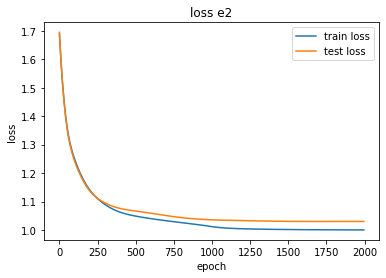

In [18]:
fig = plt.figure()
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(loss_hist),label="train loss")
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(loss_hist_test),label="test loss")


plt.legend()
plt.title("loss e2",)
plt.xlabel("epoch")
plt.ylabel("loss")

print("loss:",loss_hist[-1])

In [19]:
name = "training_e2"

Circuit_prop={   "shots":shots, "nr_trash":nr_trash, "nr_latent":nr_latent "nr_ent":nr_ent  }
Training_param = { "num_samples" = num_samples
                    "batch_size" = batch_size
                    "nr_layers"= nr_layers
                    "epochs" = epochs,
                    "learning_rate" = learning_rate 
                    "beta1" = beta1
                    "beta2 "= beta2
                     "optimizer":"Adam"}

performance={"loss_hist":loss_hist, "fid_hist":fid_hist,
             "loss_hist_test":loss_hist_test, "fid_hist_test":fid_hist_test,
             "encoder_params":encoder_params}

experiment_data={"Circuit_prop":Circuit_prop,
                "Training_param":Training_param,
                "performance:":performance,
                "Name":name}

# open file for writing
f = open(name+".txt","w")
f.write( str(experiment_data) )

SyntaxError: invalid syntax (Temp/ipykernel_2756/3056439676.py, line 3)